In [1]:
from pyrosetta import *
from pyrosetta.rosetta import *
from pyrosetta.rosetta.core.id import *
import numpy as np
import itertools
import scipy
import scipy.linalg
import matplotlib
import matplotlib.pyplot as plt
init()

Found rosetta database at: /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database; using it....
PyRosetta-4 2017 [Rosetta PyRosetta4.Release.python27.ubuntu 2018.11+release.7c7790f7c7790fbb898f8210b54513b9f9c8a927c3e8d7f 2018-03-14T13:19:04] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.

core.init: Checking for fconfig files in pwd and ./rosetta/flags

core.init: Rosetta version: PyRosetta4.Release.python27.ubuntu r173 2018.11+release.7c7790f 7c7790fbb898f8210b54513b9f9c8a927c3e8d7f http://www.pyrosetta.org 2018-03-14T13:19:04
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=125290798 seed_offset=0 real_seed=125290798
core.init.random: RandomGenerator:i

In [2]:
pose = rosetta.protocols.recces.pose_setup_turner('aa','')
pmm = PyMOLMover()
pmm.keep_history(True)

core.chemical.GlobalResidueTypeSet: Finished initializing fa_standard residue type set.  Created 603 residue types
core.chemical.GlobalResidueTypeSet: Total time to initialize 0.859375 seconds.
core.scoring.etable: Starting energy table calculation
core.scoring.etable: smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: smooth_etable: spline smoothing lj etables (maxdis = 6)
core.scoring.etable: smooth_etable: spline smoothing solvation etables (max_dis = 6)
core.scoring.etable: Finished calculating energy tables.
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBPoly1D.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBFadeIntervals.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBEval.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/DonStrength.csv
basic.io.database: Database file opened:

In [3]:
def numpy_hessian(x, h):
        
    x_grad = np.gradient(x, h)
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype = x.dtype)
    
    for k, grad_k in enumerate(x_grad):
        tmp_grad = np.gradient(grad_k, h)
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
            
    return hessian

In [11]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [171]:
def is_repeat_minimum(new_dofs, dof_lists):
    
    dofs_rounded = np.around(new_dofs, decimals=1)
    
    if len(dof_lists) == 0:
        
        return False 
    
    for dof_list in dof_lists:
        
        dof_list_rounded = np.around(dof_list, decimals=1)

        return np.all(abs(dof_list_rounded - dofs_rounded) < 60.0)
        
        #print truth_vals
        #if truth_vals == False:
        
         #   return False
    
    return True

In [172]:
def initialiize_pose(seq):
    
    n_residues = len(seq)
    
    dof_dict = {}
    
    pose = pyrosetta.rosetta.protocols.recces.pose_setup_turner(seq, '')
    movemap = MoveMap()
    
    for ii in range(n_residues-1):
            
        dof_dict.update({0: TorsionID(1, BB, 4), 1: TorsionID(1, BB, 5), 2: TorsionID(1, BB, 6), 3: TorsionID(1, CHI, 1),
                         4: TorsionID(2, BB, 1), 5: TorsionID(2, BB, 2), 6: TorsionID(2, BB, 3), 7:TorsionID(2, CHI, 1)})

        movemap.set(TorsionID(1, BB, 4), True)
        movemap.set(TorsionID(1, BB, 5), True)
        movemap.set(TorsionID(1, BB, 6), True)
        movemap.set(TorsionID(2, BB, 1), True)
        movemap.set(TorsionID(2, BB, 2), True)
        movemap.set(TorsionID(2, BB, 3), True)
        
    movemap.set_chi(True)
        
    return pose, movemap, dof_dict    
    

In [5]:
def calculate_hessian(pose, scorefxn, dof_dict):
    '''Take a minimized pose and computes the hessian at the base of the corresponding energy well. Returns the hessian matrix
    which may subsequently be diagonalized'''

    minimum = Pose()
    minimum.assign(pose)

    h = 0.1
    h_rad = h*np.pi/180
    E_0 = scorefxn(pose)

    dofs = []

    for val in dof_dict.itervalues(): dofs.append(pose.torsion(val))
    dofs = np.array(dofs)

    hessian = np.zeros((len(dofs), len(dofs)))

    n_pts = int(1/h + 1)
    ind = int(n_pts/2)

    tor_ranges = np.zeros((n_pts, len(dofs)))
    energy = np.zeros((n_pts, n_pts))

    for ii, dof in enumerate(dofs):

        tor_ranges[:, ii] = dof + np.arange(-0.5, 0.5+h, h)

    for pair in list(itertools.combinations(dof_dict.keys(), 2)):

        foo = pair[0]
        bar = pair[1]

        x = tor_ranges[:, foo]
        y = tor_ranges[:, bar]

        for ii, xx in enumerate(x):

            pose.set_torsion(dof_dict[pair[0]], xx)

            for jj, yy in enumerate(y):

                pose.set_torsion(dof_dict[pair[1]], yy)

                energy[ii, jj] = scorefxn(pose)

                pose.set_torsion(dof_dict[pair[1]], dofs[bar])

            pose.set_torsion(dof_dict[pair[0]], dofs[foo])

        hess = numpy_hessian(energy, h_rad)

        d2E_dx2 =  hess[0,0,:,:]
        d2E_dy2 =  hess[1,1,:,:]
        d2E_dxdy = hess[0,1,:,:]

        if hessian[foo, foo] == 0:

            hessian[foo, foo] = d2E_dx2[ind, ind]

        if hessian[bar, bar] == 0:

            hessian[bar, bar] = d2E_dy2[ind, ind]

        hessian[foo, bar] = d2E_dxdy[ind, ind]
        hessian[bar, foo] = d2E_dxdy[ind, ind]
        
    return hessian


In [6]:
def mode_scan(pose, dofs, dof_dict, scorefxn, mode, kT = 1.0, h = 0.5):
    
    temp = Pose()
    temp.assign(pose)
    
    E_0 = scorefxn(pose)
    E = E_0
    inc = 0
    result = 0.0
    
    max_inc = int(60/h)

    while inc < max_inc:
        
        inc += 1
        result += 0.5*np.exp(-(E-E_0)/kT)
        dofs_new = dofs + (60.0)*inc/float(max_inc)*mode
        
        for key, val in enumerate(dofs_new):

            temp.set_torsion(dof_dict[key], val)
        
        E = scorefxn(temp)
        result += 0.5*np.exp(-(E-E_0)/kT)

    # Reinitialize pose
    temp.assign(pose)
    inc = 0
    E = E_0
    
    while inc < max_inc:
        
        inc += 1
        
        result += 0.5*np.exp(-(E-E_0)/kT)
        dofs_new = dofs + 60.0*inc/float(max_inc)*mode
        
        for key, val in enumerate(dofs_new):
    
            temp.set_torsion(dof_dict[key], val)
        
        E  = scorefxn(temp)
        result += 0.5*np.exp(-(E-E_0)/kT)
        
    result *= h*np.pi/180.0
    return result


In [7]:
rna_hires = protocols.rna.denovo.get_rna_hires_scorefxn()
#rna_hires = core.scoring.ScoreFunctionFactory.create_score_function('rna/denovo/rna_hires_recces')
#rna_hires.set_weight(core.scoring.geom_sol, 0)
#rna_hires.set_weight(core.scoring.ch_bond, 0)
#rna_hires.set_weight(core.scoring.rna_sugar_close, 0)
rna_hires.set_weight(core.scoring.ch_bond, 0.)
rna_hires.set_weight(core.scoring.rna_sugar_close, 0.)
rna_hires.set_weight(core.scoring.hbond_lr_bb_sc, 0.)
rna_hires.set_weight(core.scoring.hbond_sr_bb_sc, 0.)
rna_hires.set_weight(core.scoring.hbond_sc, 0.)
rna_hires.set_weight(core.scoring.geom_sol, 0.)
rna_hires.set_weight(core.scoring.atom_pair_constraint, 0.)
rna_hires.set_weight(core.scoring.fa_atr,0.73)
rna_hires.set_weight(core.scoring.fa_rep, 0.10)
rna_hires.set_weight(core.scoring.fa_intra_rep, 0.0071) 
rna_hires.set_weight(core.scoring.lk_nonpolar, 0.25) 
rna_hires.set_weight(core.scoring.fa_elec_rna_phos_phos, 4.54) 
rna_hires.set_weight(core.scoring.rna_torsion, 4.26) 
rna_hires.set_weight(core.scoring.stack_elec, 1.54) 
rna_hires.set_weight(core.scoring.hbond_sc, 2.46)
scorefxn = rna_hires

core.scoring.etable: Starting energy table calculation
core.scoring.etable: smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: smooth_etable: spline smoothing lj etables (maxdis = 6)
core.scoring.etable: smooth_etable: spline smoothing solvation etables (max_dis = 6)
core.scoring.etable: Finished calculating energy tables.
basic.io.database: Database file opened: scoring/score_functions/carbon_hbond/ch_o_bond_potential.dat


In [224]:
seq = 'ga'
n = len(seq)
mu_list = []
pmm = PyMOLMover()
pmm.keep_history(True)
E_list = []
i = 0
dof_lists = []

In [225]:
# Code for a purine stacked on a purine

for delta in [84.4, 145.4]:
    
    for alpha in [-64.3, 66.7, 156.6]:
        
        pose, movemap, dof_dict = initialiize_pose(seq)
        
        # These will set the terminal base pair to C2'-endo (south)
        #pose.set_torsion(TorsionID(n, BB, 4), 145.5)
        #pose.set_torsion(TorsionID(n, CHI, 2), -37.2)
        #pose.set_torsion(TorsionID(n, CHI, 3), 155.5)
        
        # C3'-endo
        if delta == 84.4:
            
            possible_chi = [-110.9, -51.9, 72.4]
            possible_eps = [-150.4, 16.8, 76.2]
            
        #C2'-endo
        else:
            
            possible_chi = [-56.6, 119.0]
            possible_eps = [-97.4, 0, 75.2]
            
            for ii in range(len(seq)-1):
                
                pose.set_torsion(TorsionID(ii+1, CHI, 2), -37.2)
                pose.set_torsion(TorsionID(ii+1, CHI, 3), 155.5)
                
        if alpha == -64.3: possible_zeta = [-71.8, 167.55]
        elif alpha == 66.7: possible_zeta = [-69.5, 56.5]
        else: possible_zeta = [-131.6, 79.]
        
        
        torsion_lists = itertools.product([delta], possible_eps, possible_zeta, possible_chi, [alpha], [177.3], 
                                          [-62.9, 53.5, 175.8],[-56.6, 119.0])
        
        
        
        for torsion_list in list(torsion_lists):
            
            pose.set_torsion(TorsionID(1, BB, 4), torsion_list[0])
            pose.set_torsion(TorsionID(1, BB, 5), torsion_list[1])
            pose.set_torsion(TorsionID(1, BB, 5), torsion_list[2])
            pose.set_torsion(TorsionID(1, CHI, 1), torsion_list[3])
            pose.set_torsion(TorsionID(2, BB, 1), torsion_list[4])
            pose.set_torsion(TorsionID(2, BB, 2), torsion_list[5])
            pose.set_torsion(TorsionID(2, BB, 3), torsion_list[6])
            pose.set_torsion(TorsionID(2, CHI, 1), torsion_list[7])
        
            minmover = rosetta.protocols.minimization_packing.MinMover(movemap, scorefxn, 'lbfgs_armijo', 1.0e-7, True)
            minmover.max_iter(1000000)
            minmover.min_options().use_nblist(True)
            minmover.min_options().nblist_auto_update(True)
            minmover.apply(pose)
            pmm.apply(pose)

            E_min = scorefxn(pose)
            
            
            minimum = Pose()
            minimum.assign(pose)
            
            dofs = []

            for val in dof_dict.itervalues(): dofs.append(pose.torsion(val))
            dofs = np.array(dofs)

            if is_repeat_minimum(dofs, dof_lists):
                
                continue
                
            dof_lists.append(dofs)
                    
                    
            hessian = calculate_hessian(pose, scorefxn, dof_dict)
            w,v = scipy.linalg.eigh(hessian)

            if not np.all(w > 0.):
                continue

                        
            #for E in E_list: 
            #    
            #    if abs(E-E_min) < 0.01: 
            #        i = 1
            #        break
            #        
            #if i == 1: 
            #    i = 0
            #    continue
            

            E_list.append(E_min)
            Z = 1

            for kk, K in enumerate(w):

                Z *= mode_scan(pose, dofs, dof_dict, scorefxn, v[:,kk])

            #mu_list.append(scorefxn(minimum) - 0.6163*np.log(Z))
            mu_list = np.append(mu_list, scorefxn(minimum)- 0.6163*np.log(Z))

'''
# South, anti
pose.set_torsion(TorsionID(1, BB, 4), 145.4)
pose.set_torsion(TorsionID(1, BB, 5), -97.4)
pose.set_torsion(TorsionID(1, CHI, 1), -56.6)
pose.set_torsion(TorsionID(1, CHI, 2), -37.2)
pose.set_torsion(TorsionID(1, CHI, 3), 155.5)
pose.set_torsion(TorsionID(2, BB, 1), 66.7)
pose.set_torsion(TorsionID(2, BB, 3), -62.9)
pose.set_torsion(TorsionID(2, BB, 4), 145.4)
pose.set_torsion(TorsionID(2, CHI, 1), -56.6)
pose.set_torsion(TorsionID(2, CHI, 2), -37.2)
pose.set_torsion(TorsionID(2, CHI, 3), 155.5)
'''

core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 1.90735e-06 Deriv= -2.30989e-05 Finite Diff= 9.81342e-05
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-06 Deriv= -0.0012555 Finite Diff= -8.26257e-05
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-06 Deriv= -2.67858e-05 Finite Diff= 3.92096e-05
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-06 Deriv= -3.73256e-05 Finite Diff= 0.000407484
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 1.90735e-06 Deriv= -0.00404055 Finite Diff= -0.000221478
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 1.90735e-06 Deriv= -0.00744434 Finite Diff= 0.000208018
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 1.90735e-06 Deriv= -9.66369e-05 Finite Diff= 5.81434e-05
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 1.90735e-06 Deriv= -0.000477274 Finite Diff= 0.000376552
core.optimization.LineMinimizer: [ ERROR ] In

core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 2.98023e-08 Deriv= -0.00872759 Finite Diff= -0.000857502
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 1.19209e-07 Deriv= -2.82962e-05 Finite Diff= -1.78814e-06
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 1.90735e-06 Deriv= -0.0002544 Finite Diff= 0.000105936
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 5.96046e-08 Deriv= -0.00251923 Finite Diff= 0.00110707
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-06 Deriv= -0.000722136 Finite Diff= 9.62443e-05
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 9.53674e-07 Deriv= -2.89581e-05 Finite Diff= 1.06355e-05
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-06 Deriv= -0.00237491 Finite Diff= -0.000120967
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 9.53674e-07 Deriv= -0.00202449 Finite Diff= 0.000110457
core.optimization.LineMinimizer: [ ERROR ] Ina

core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 4.76837e-07 Deriv= -0.00418272 Finite Diff= -0.000225242
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-06 Deriv= -7.93203e-05 Finite Diff= 8.45292e-06
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 4.76837e-07 Deriv= -0.000381295 Finite Diff= -1.55233e-05
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 1.90735e-06 Deriv= -0.000444839 Finite Diff= 4.28884e-05
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-06 Deriv= -0.000115249 Finite Diff= 9.96981e-06
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-06 Deriv= -0.000739298 Finite Diff= -3.99264e-05
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 1.90735e-06 Deriv= -0.000209763 Finite Diff= -2.08206e-05
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-06 Deriv= -0.000560513 Finite Diff= -2.68067e-05
core.optimization.LineMinimizer: [ ERROR

core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-06 Deriv= -6.56871e-05 Finite Diff= 1.72295e-06


'\n# South, anti\npose.set_torsion(TorsionID(1, BB, 4), 145.4)\npose.set_torsion(TorsionID(1, BB, 5), -97.4)\npose.set_torsion(TorsionID(1, CHI, 1), -56.6)\npose.set_torsion(TorsionID(1, CHI, 2), -37.2)\npose.set_torsion(TorsionID(1, CHI, 3), 155.5)\npose.set_torsion(TorsionID(2, BB, 1), 66.7)\npose.set_torsion(TorsionID(2, BB, 3), -62.9)\npose.set_torsion(TorsionID(2, BB, 4), 145.4)\npose.set_torsion(TorsionID(2, CHI, 1), -56.6)\npose.set_torsion(TorsionID(2, CHI, 2), -37.2)\npose.set_torsion(TorsionID(2, CHI, 3), 155.5)\n'

In [226]:
import scipy.special
print len(mu_list)
mu_list = np.array(mu_list)
print 0.6163*(-scipy.special.logsumexp(-mu_list[:]/0.6163) - 8*np.log(2*np.pi/3) - 2*np.log(2))

499
-11.031204744410637


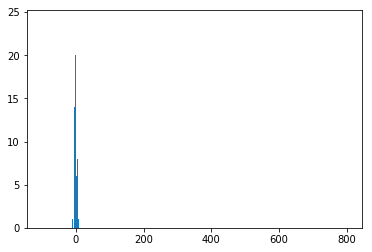

In [192]:
hist = plt.hist(E_list,bins=9000,range=(-100,800))

-10.4302911865
Inferring sequence from directory name:  gu
applying phase space volume for single strand with length  2


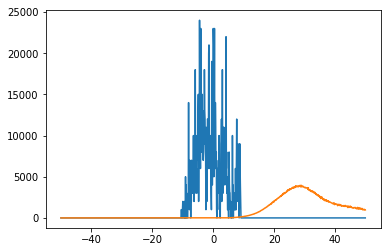

In [212]:
from scipy.special import logsumexp
from recces.data import SingleHistSimulation
from recces.util import torsion_volume
print min(E_list)
sim = SingleHistSimulation('./../recces_rosetta/results/gu/ST/')
plt.plot(hist[1][500:1500], hist[0][500:1500]*1000)
plt.plot(sim._dos_scores[500:1500], sim._dos[500:1500])

In [210]:
minmover.apply(pose)
pmm.apply(pose)
hessian = calculate_hessian(pose, scorefxn, dof_dict)

dofs = []
for val in dof_dict.itervalues(): dofs.append(pose.torsion(val))
dofs = np.array(dofs)

In [212]:
w, v = scipy.linalg.eigh(hessian)
obs = protocols.moves.AddPyMOLObserver(pose, True)
pose.assign(minimum)
E_min = scorefxn(minimum)

In [213]:
print scorefxn(minimum) - 0.5*len(w)*np.log(2*np.pi) + 0.5*np.log(scipy.linalg.det(hessian))

4.635484102907595


In [214]:
import scipy.integrate

Z = 1

#pose.assign(minimum)
#E_min = scorefxn(minimum)
kT = 1.0
fig = plt.figure()
for kk in range(1):
 
    mode = v[:,kk]
    h = range(-30,31,1)
    fuck = h[:-1]
    fuck.reverse()
    h = h+fuck
    h = np.array(h)
    h_plot = h*np.pi/180

    bar = []


    for hh in h:

        dofs_new = dofs+hh*mode

        for jj, dof in enumerate(dofs_new):

            pose.set_torsion(dof_dict[jj], dof)

        bar.append((scorefxn(pose)-E_min)/kT)

    
    #Z *= np.trapz(np.exp(-np.array(bar)), dx = np.pi/180.)
    #np.array(bar) 
    #pose.assign(minimum)
    #plt.subplot(3, 4, kk+1)
    #plt.plot(h, np.exp(-np.array(bar)))
    #plt.plot(h, np.exp(-0.5*K*h_plot**2/kT))
    #plt.xlabel('Displacement along normal coordinate (degrees)')
    #plt.ylabel('exp(-(E-E0)/kT)')

<Figure size 432x288 with 0 Axes>

In [204]:
print scorefxn(minimum) - np.log(Z)

4.718522734400645


In [73]:
print v


[[ 3.13398455e-03  8.64420677e-03  3.68804885e-03  2.97168791e-03
   9.99834374e-01 -1.20069209e-02 -9.02758608e-05  8.94317886e-03
  -3.03893335e-04]
 [ 7.43672169e-01  1.37788517e-01 -8.06782577e-02 -2.98502580e-01
   6.08882793e-04 -1.87663655e-02  1.37118851e-01 -3.67554660e-01
  -4.22022160e-01]
 [-1.54162211e-01  4.42909860e-01  1.51487364e-01 -1.31756584e-01
   4.55793204e-03  5.67249130e-01 -6.09307571e-01 -1.52130848e-01
  -1.53508267e-01]
 [-2.92181809e-01 -5.83755716e-01 -3.17967688e-01 -6.20706248e-01
   1.29391515e-02  1.56828418e-01 -8.18034693e-02 -2.34042435e-01
  -3.53428109e-02]
 [ 2.29178072e-01 -6.02057891e-01  3.71256541e-01  2.48971232e-01
   4.19662050e-04  5.97411537e-02 -3.69144112e-01  2.81502867e-01
  -4.07560048e-01]
 [-4.92517350e-01  1.76142167e-01  3.56104228e-01 -1.84902970e-01
  -3.96887658e-03 -2.53554658e-01  3.05557534e-01  1.61272659e-03
  -6.38535468e-01]
 [-3.45880774e-02  1.77312089e-01 -7.05950039e-01  4.09670280e-02
  -5.79687831e-03 -2.2100899

In [74]:
print pose.epsilon(1)

-147.213383076
